# Conditioning a Gaussian distribution on a system of linear equations

## Problem Statement

Conditioning a multivariate Gaussian random variable in the canonical parameterization form $\mathbf x \sim \mathcal{N}\left[\mathbf A, \mathbf b\right]$ on observed values for a subset of its dimensions is notoriously simple.  Let $\mathbf x$ be arbitrarily split into two components $\mathbf x^\top = \left( \mathbf x_1^\top, \mathbf x_2^\top \right)$, with the corresponding decomposition of its distribution parameters

$$
\operatorname{pr}\left(\begin{pmatrix} \mathbf x_1 \\ \mathbf x_2 \end{pmatrix} \right)= \mathcal{N} \left[
\begin{bmatrix} \mathbf A_{11} & \mathbf A_{12} \\ \mathbf A_{21} & \mathbf A_{22} \end{bmatrix},
\begin{pmatrix} \mathbf b_1 \\ \mathbf b_2 \end{pmatrix}
\right] \,.
$$

Then, we can condition on an observation of one component $\mathbf x_1$ and obtain a posterior distribution on the other unobserved component $\mathbf x_2$:

$$
\operatorname{pr}\left( \mathbf x_2 ~|~ \mathbf x_1 \right) = \mathcal{N}\left[ \mathbf A_{22}, \mathbf b_2 - \mathbf A_{21} \mathbf x_1 \right] \,.
$$

The above equation works for all cases where the observations perfectly align with the predefined dimensional axes of the vector space.  However, it does not address the more general set of possible observations which are represented by linear combinations, e.g. $\mathbf v^\top \mathbf x_1 = c$.
The question thus becomes, how do we condition on a general system of linear equations $\operatorname{pr}(\mathbf x ~|~ \mathbf C\mathbf x = \mathbf d)$?


## Solution

Let $\mathbf x\sim\mathcal{N}[\mathbf A, \mathbf b]$ be a $d$-dimensional random variable, and let $\mathbf C\mathbf x = \mathbf d$ be a system of $k$ linear equations with $\mathbf C\in\mathbb{R}^{k \times d}$ and $\mathbf d\in\mathbb{R}^k$.

Assuming that the system $\mathbf C\mathbf x = \mathbf d$ is satisfiable, its solutions are described by the set $\mathbf x^\star = \mathbf C^+ \mathbf d + \mathbf w$, where $\mathbf w\in\operatorname{null}\mathbf C$.  The $\mathbf C^+\mathbf d$ component is that which is fixed by the constraints, whereas the $\mathbf w$ is a free variable living in a $(d-k)$-dimensional subspace.  Using the SVD of $\mathbf C = U S V^\top$ we obtain $V_\perp V_\perp^\top$, the projection operator onto the nullspace $\operatorname{null}\mathbf C$.  By definition, $\mathbf w\in\operatorname{null}\mathbf C$ which implies the identity

$$
\mathbf w = V_\perp \underbrace{V_\perp^\top \mathbf w}_\mathbf z \,,
$$

where we define $\mathbf z = V_\perp^\top \mathbf w$ to be the $(d-k)$-dimensional free variable in latent space corresponding to the free variable $\mathbf w$.  We now take the canonical Gaussian neg-log likelihood and substitute $\mathbf x$ for the general system solution $\mathbf x^\star$,

$$
\begin{align}
\operatorname{nll}[\mathbf x ~|~ \mathbf A, \mathbf b] &\stackrel{+c}{=} -\frac{1}{2} \mathbf x^\top \mathbf A\mathbf x + \mathbf x^\top\mathbf b \\
&= -\frac{1}{2} (\mathbf C^+ \mathbf d + \mathbf w) ^\top \mathbf A (\mathbf C^+ \mathbf d + \mathbf w) + (\mathbf C^+ \mathbf d + \mathbf w)^\top \mathbf b \\
&\stackrel{+c}{=} -\frac{1}{2} \mathbf w^\top \mathbf A \mathbf w + \mathbf w^\top (\mathbf b - \mathbf A\mathbf C^+\mathbf d) \,,
\end{align}
$$
    
and apply the substitution $\mathbf w = V_\perp \mathbf z$,

$$
\begin{equation}
= -\frac{1}{2} \mathbf z^\top \underbrace{V_\perp^\top \mathbf A V_\perp}_{\mathbf A_\mathbf z}\mathbf z + \mathbf z^\top \underbrace{V_\perp^\top (\mathbf b - \mathbf A\mathbf C^+\mathbf d)}_{\mathbf b_\mathbf z} \,.
\end{equation}
$$

The result is a non-degenerate posterior distribution on the latent subspace variable $\operatorname{pr}(\mathbf z ~|~ \mathbf C\mathbf x = \mathbf d) = \mathcal{N}\left[\mathbf z ~|~ \mathbf A_\mathbf z, \mathbf b_\mathbf z \right]$ which is informed and shaped by the given constraints $\mathbf C \mathbf x = \mathbf d$.  This distribution gives us a simple way to sample $\mathbf x\sim\operatorname{pr}(\mathbf x ~|~ \mathbf C\mathbf x=\mathbf d)$ as follows:

$$
\begin{align}
\mathbf z &\sim \mathcal{N}\left[\mathbf A_\mathbf z, \mathbf b_\mathbf z \right] \,, \\
\mathbf x &= \mathbf C^+\mathbf d + V_\perp \mathbf z \,.
\end{align}
$$

To verify that this analytical result is indeed the correct solution to our problem, we are going to compare the resulting samples to an---less efficient---way to obtain similar data.  First, we implement the above procedure.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns; sns.set()
import pandas

import numpy as np
import numpy.linalg as la
import numpy.random as rnd

from scipy.stats import multivariate_normal

In [2]:
class GeneralGaussianPosterior:
    def __init__(self, S, m):
        """ Initialize Gaussian parameters N(m, S) """
        
        self.x_rv = multivariate_normal(mean=m, cov=S)
        
        # Canonical parametrization of Gaussian rules
        self.A = la.inv(S)
        self.b = np.dot(self.A, m)
    
    def condition(self, C, d):
        """ Condition Gaussian on Cx = d """
        
        # Quantities needed to sample in latent space and embed back in ambient space
        U, S, V = la.svd(C, full_matrices=1)
        rank = len(S)
        self.V_orth = V[rank:, :].T
        self.CPId = np.dot(la.pinv(C), d)
        
        # Posterior Gaussian params in latent space
        Az = la.multi_dot([self.V_orth.T, self.A, self.V_orth])
        bz = np.dot(self.V_orth.T, self.b - np.dot(self.A, self.CPId))
        
        Sz = la.inv(Az)
        mz = np.dot(Sz, bz)
        self.z_rv = multivariate_normal(mean=mz, cov=Sz)
        
    def sample_prior(self, n):
        """ Sample from prior N[A, b] """
        return self.x_rv.rvs(size=n).reshape((n, -1))
        
    def sample_latent(self, n):
        """ Sample from latent space posterior distribution """
        return self.z_rv.rvs(size=n).reshape((n, -1))

    def embed(self, Z):
        """ Embed latent variables back into ambient space """
        return self.CPId + np.dot(Z, self.V_orth.T)
        
    def sample_posterior(self, n):
        """ Sample from posterior N[A, b | Cx = d] """
        Z = self.sample_latent(n)
        return self.embed(Z)

In [3]:
# Space dimensionality
ndim = 3

# Selecting a random centered Gaussian distribution
S = np.triu(rnd.uniform(-1, 1, (ndim, ndim)))
S = np.dot(S, S.T)
m = np.zeros(ndim)

# Set your own constraints M = [C, d] ...
M = np.array([
    [1, -1, 0, 0],
    [0, 1, 1, 0]
])

# ... or use random ones
ncons = 1
M = rnd.uniform(-1, 1, (ncons, ndim+1))

C = M[:, :-1]
d = M[:, -1].ravel()

cg = GeneralGaussianPosterior(S, m)
cg.condition(C, d)

In [4]:
def customize_offdiag(x, y, **kwargs):
    plt.axhline(0, color='black', linewidth=1)
    plt.axvline(0, color='black', linewidth=1)

def pairplot(data, title):
    df = pandas.DataFrame(data)
    pp = sns.pairplot(df,
                      diag_kind='kde', diag_kws=dict(shade=True),
                      markers='.', plot_kws=dict(s=50, edgecolor='b', linewidth=1, alpha=.1)
                     )
    pp.map_offdiag(customize_offdiag)
    
    pp.set(aspect = 'equal')
    for ax in pp.axes.flat:
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.subplots_adjust(top=.9)
    sns.plt.suptitle(title)


ndata = 1000

# Analytical prior, latent and posterior samples
X_prior = cg.sample_prior(ndata)
Z = cg.sample_latent(ndata)
X_post = cg.embed(Z)

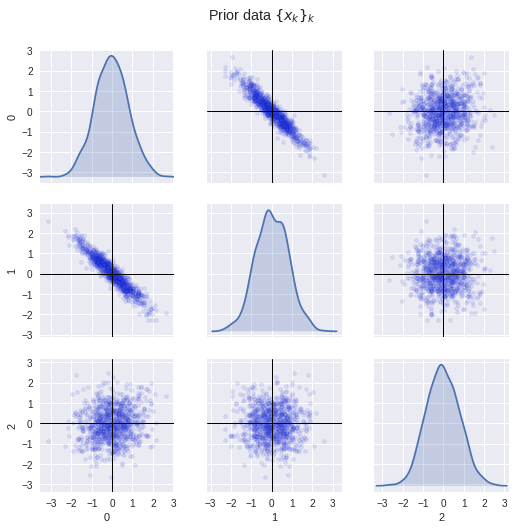

In [5]:
pairplot(X_prior, 'Prior data $\{x_k\}_k$')

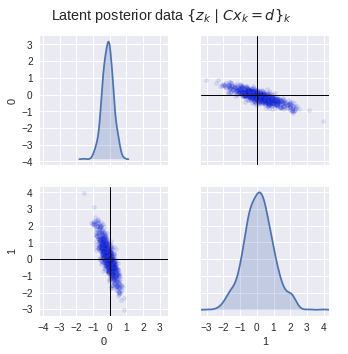

In [6]:
pairplot(Z, 'Latent posterior data $\{z_k\mid Cx_k=d\}_k$')

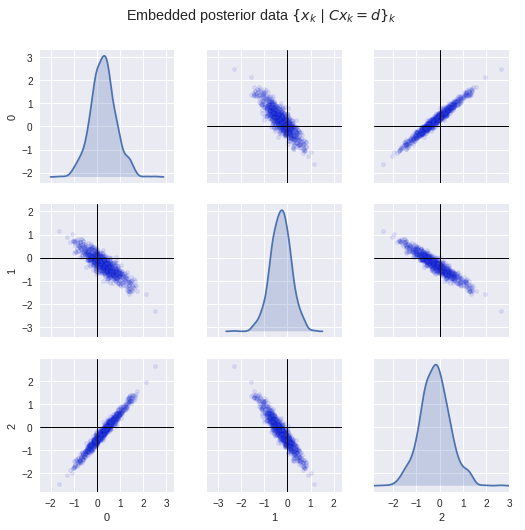

In [7]:
pairplot(X_post, 'Embedded posterior data $\{x_k\mid Cx_k=d\}_k$')

## Verification (via rejection sampling)

We verify that the sampling procedure is by comparing it to approximatively correct data.  We use rejection sampling to collect the ground truth data, i.e. we sample data-points from the prior distribution, and reject all those for which the observation error is higher than a predefined threshold $\| \mathbf C\mathbf x-\mathbf d \|_\infty > 0.01$.  

Rejection sampling is not a good way to solve the problem itself because there is a strong tradeoff (controlled by the rejection error threshold) between the precision of the posterior data and the computational time required to sample it.  However, it serves perfectly for the purpose of validating our analytical solution which, should it be proven correct, is both faster and more precise.

If our solution is correct, the posterior data graphs should look similar.

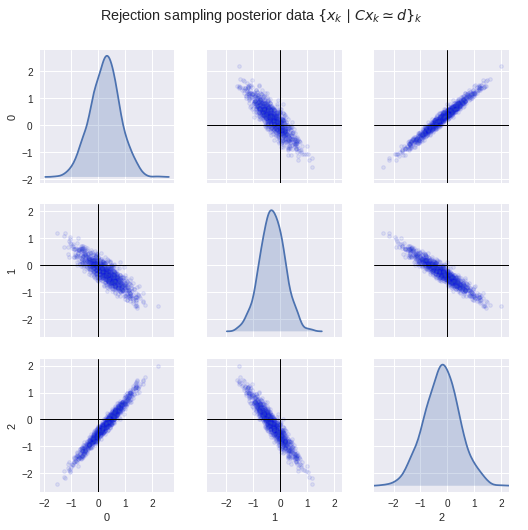

In [8]:
# Rejection sampling posterior samples
n = 0
X_post_rej = []
while n < ndata:
    X = cg.sample_prior(ndata)
    error = np.dot(C, X.T) - d[:, np.newaxis]
    accepted = la.norm(error, np.inf, axis=0) <= .01
    X_post_rej.append(X[accepted, :])
    n += accepted.sum()
X_post_rej = np.vstack(X_post_rej)

# NOTE that the more constraints the are, the less similar the graphs will be
pairplot(X_post_rej, 'Rejection sampling posterior data $\{x_k \mid Cx_k \simeq d\}_k$')